# Midterm 3 - Assignment 3

Train a neural network for sequences of your choice (LSTM, GRU, Convolutional, Clockwork RNN, ...) to predict the Benzene (C6H6 column) based on the sensor measurements timeseries (PT08.* columns) being fed in input to the recurrent model. Evaluate the predictive accuracy of the network on the task (using appropriately training/validation splits).  Confront the perfomance of this model, with another recurrent neural network trained to predict benzene one-step-ahead, i.e. given the current benzene measuement, predict its next value.
Show and compare performance of both settings.

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Input
import keras
from pandas import DataFrame
from pandas.plotting import autocorrelation_plot
from scipy.stats import probplot

In [ ]:
# Importing the data
df = pd.read_csv(
    'https://raw.githubusercontent.com/cpic29/ISPR/main/AirQualityUCI.csv',
    delimiter=';',
    nrows=9357,
    usecols=['Date', 'Time', 'PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'C6H6(GT)']
)

date_time_format = '%d/%m/%Y %H.%M.%S'
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format=date_time_format)
df.drop(['Date', 'Time'], axis=1, inplace=True)
df['C6H6(GT)'] = df['C6H6(GT)'].str.replace(',', '.').str.strip().replace(' ', '')

for column in df.columns:
    if column != 'Datetime':
        df[column] = pd.to_numeric(df[column], errors='coerce')
        df[column] = df[column].replace(-200, np.nan)
        df[column] = df[column].interpolate(limit=1)


for column in df.columns:
    nan_indices = []
    if column != 'Datetime':
        nan_indices = np.where(df[column].isna())[0]
        for index in nan_indices:
            prev_time = df.loc[index, 'Datetime'] - pd.Timedelta(hours=24)
            prev_value = df.loc[df['Datetime'] == prev_time, column].values
            df.loc[index, column] = prev_value[0]

# Set 'Datetime' as the index of the DataFrame
df.set_index('Datetime', inplace=True)

In [ ]:
# The target column becomes the last one
target_column = 'C6H6(GT)'
ordered_columns = [c for c in df.columns if c != target_column] + [target_column]
df = df[ordered_columns]

In [ ]:
# Split the dataset in training, validation and test
test_split = len(df) - round(len(df) * 0.20)
test = df[test_split:]
train = df[:test_split]

val_split = len(train) - round(len(train) * 0.20)
val = train[val_split:]
train2 = train[:val_split]

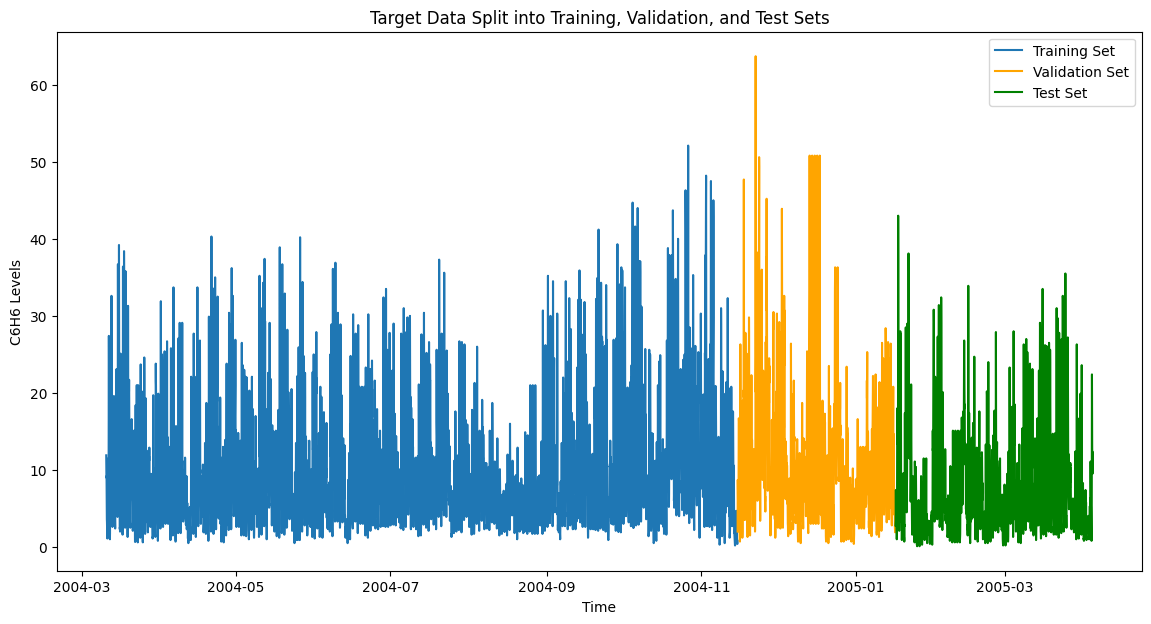

In [ ]:
plt.figure(figsize=(14, 7))

plt.plot(train2.index, train2['C6H6(GT)'], label='Training Set')
plt.plot(val.index, val['C6H6(GT)'], label='Validation Set', color='orange')
plt.plot(test.index, test['C6H6(GT)'], label='Test Set', color='green')

plt.xlabel('Time')
plt.ylabel('C6H6 Levels')
plt.title('Target Data Split into Training, Validation, and Test Sets')
plt.legend()
plt.show()

General steps of data cleaning were performed. Then, the entire time series was split into training, validation, and test sets. Since we were working with a time series, it was crucial to preserve the temporal order of the data.

## Model 1

In [ ]:
# Initialize the scaler with a specified feature range
scaler = MinMaxScaler(feature_range=(0,1))

# Fit the scaler on the training data and transform it
df_for_training_scaled = scaler.fit_transform(train2)

# Transform the validation and test sets using the same scaler
df_for_val_scaled = scaler.transform(val)
df_for_test_scaled = scaler.transform(test)

In [ ]:
def createXY(dataset,n_past):
    dataX = []
    dataY = []
    # Iterate over the dataset to create sequences of length n_past
    for i in range(n_past, len(dataset)+1):
        # Append the sequence of features (excluding the target variable)
        dataX.append(dataset[i - n_past:i, :-1])
        # Append the target variable for the last element in the sequence
        dataY.append(dataset[i-1,-1])
    return np.array(dataX),np.array(dataY)

# Create sequences of 12 past time steps for training and validation
trX,trY=createXY(df_for_training_scaled, 12)
vlX,vlY=createXY(df_for_val_scaled, 12)

In [ ]:
# Model creation
def create_model(inputx = 12, inputy = 5, units=20, dropout_rate=0.2, optimizer='adam'):
    model = Sequential()
    model.add(Input(shape=(inputx, inputy)))
    model.add(LSTM(units=units))
    model.add(Dropout(rate = dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [ ]:
model = create_model()

model.summary()

# Early stopping implementation
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True, start_from_epoch=5)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 20)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,101 (8.21 KB)

 Trainable params: 2,101 (8.21 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Fitting the model
history = model.fit(trX, trY, epochs=200, batch_size=64, validation_data=(vlX, vlY), shuffle=False, callbacks=[callback])

Epoch 1/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0153 - val_loss: 0.0077
Epoch 2/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0069 - val_loss: 0.0048
Epoch 3/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0046 - val_loss: 0.0035
Epoch 4/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0033 - val_loss: 0.0028
Epoch 5/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 6/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 7/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 8/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016 - val_loss: 0.0021
Epoch 9/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 10/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 11/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0012 - val_loss: 8.7512e-04
Epoch 12/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss:

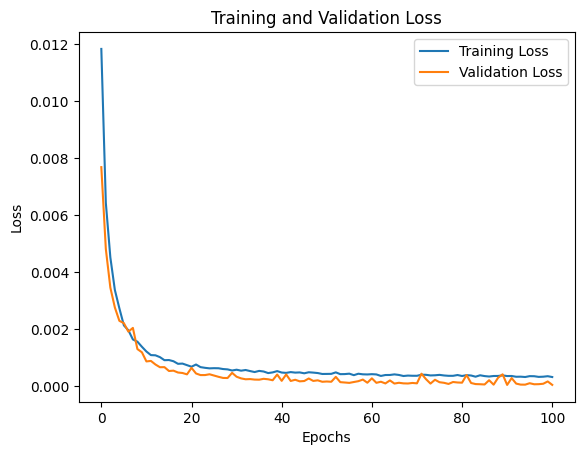

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
# Traning and validation data unified for retraining
combined_data = np.vstack((df_for_training_scaled, df_for_val_scaled))

trX,trY=createXY(combined_data, 12)
tsX,tsY=createXY(df_for_test_scaled, 12)

# Final retraining
model.fit(trX, trY, epochs=1, batch_size=64, shuffle=False)

117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.5311e-04


In [ ]:
# Model assessment
test_loss = model.evaluate(tsX, tsY)
print("Test Loss:", test_loss)

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - loss: 3.9887e-05
Test Loss: 3.9726430259179324e-05


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


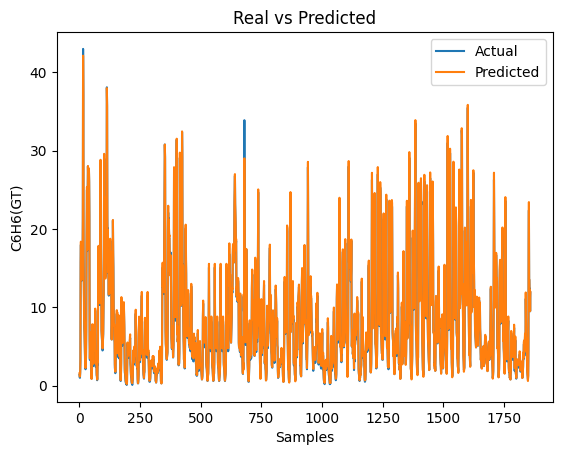

In [ ]:
# Model prediction on the test set
predictions1 = model.predict(tsX)

# Rescaling predictions and original data back to their original form
prediction_copies_array1 = np.repeat(predictions1, 6, axis=-1)
pred1=scaler.inverse_transform(np.reshape(prediction_copies_array1,(len(predictions1),6)))[:,-1]

original_copies_array1 = np.repeat(tsY,6, axis=-1)
original1=scaler.inverse_transform(np.reshape(original_copies_array1,(len(tsY),6)))[:,-1]

plt.plot(original1, label='Actual')
plt.plot(pred1, label='Predicted')
plt.xlabel('Samples')
plt.ylabel('C6H6(GT)')
plt.title('Real vs Predicted')
plt.legend()
plt.show()

From a previous data analysis conducted during the first midterm, I found out that the sensor columns PTS08* exhibit a high correlation with the C6H6(GT) column. This correlation is highest at time zero and decreases as the lag increases. Therefore, we can expect significant accuracy from a recurrent network trained on the readings of these sensors to predict benzene levels.

In this case, a single-layer LSTM recurrent network was chosen. Before feeding the data into the network, the data were first scaled using MinMaxScaler within the 0-1 range. Normalizing the data ensures that all features are on the same scale, preventing any single feature from dominating the model's learning process.

The data were transformed into overlapping sequences of 12 time steps. To predict benzene levels at time
t, the network uses the current observation and the previous 11 observations (12 observations in total). The number 12 was chosen based on the correlation analysis between benzene and the other sensors: while the correlation decreases after lag 0, there are peaks every 24 hours. However, creating sequences that are too long would result in the network receiving repetitive data due to the overlapping nature of the sequences. Therefore, a 12-time-step window was deemed appropriate to capture relevant information without introducing excessive redundancy.

The LSTM model is very simple, comprising an input layer, an LSTM layer, a dropout layer and an output layer. After model selection, the model was retrained by combining training and validation data. It is true that retraining the model without a validation set can expose it to the risk of overfitting, but especially for time series, it is important that the model is trained up to the most recent predictions (in this case, validation data).

Moreover, we can see that after evaluating the model on the test set, it appears to generalize well: the loss is very low and the model's predictions are very close to the actual values.

## Model 2

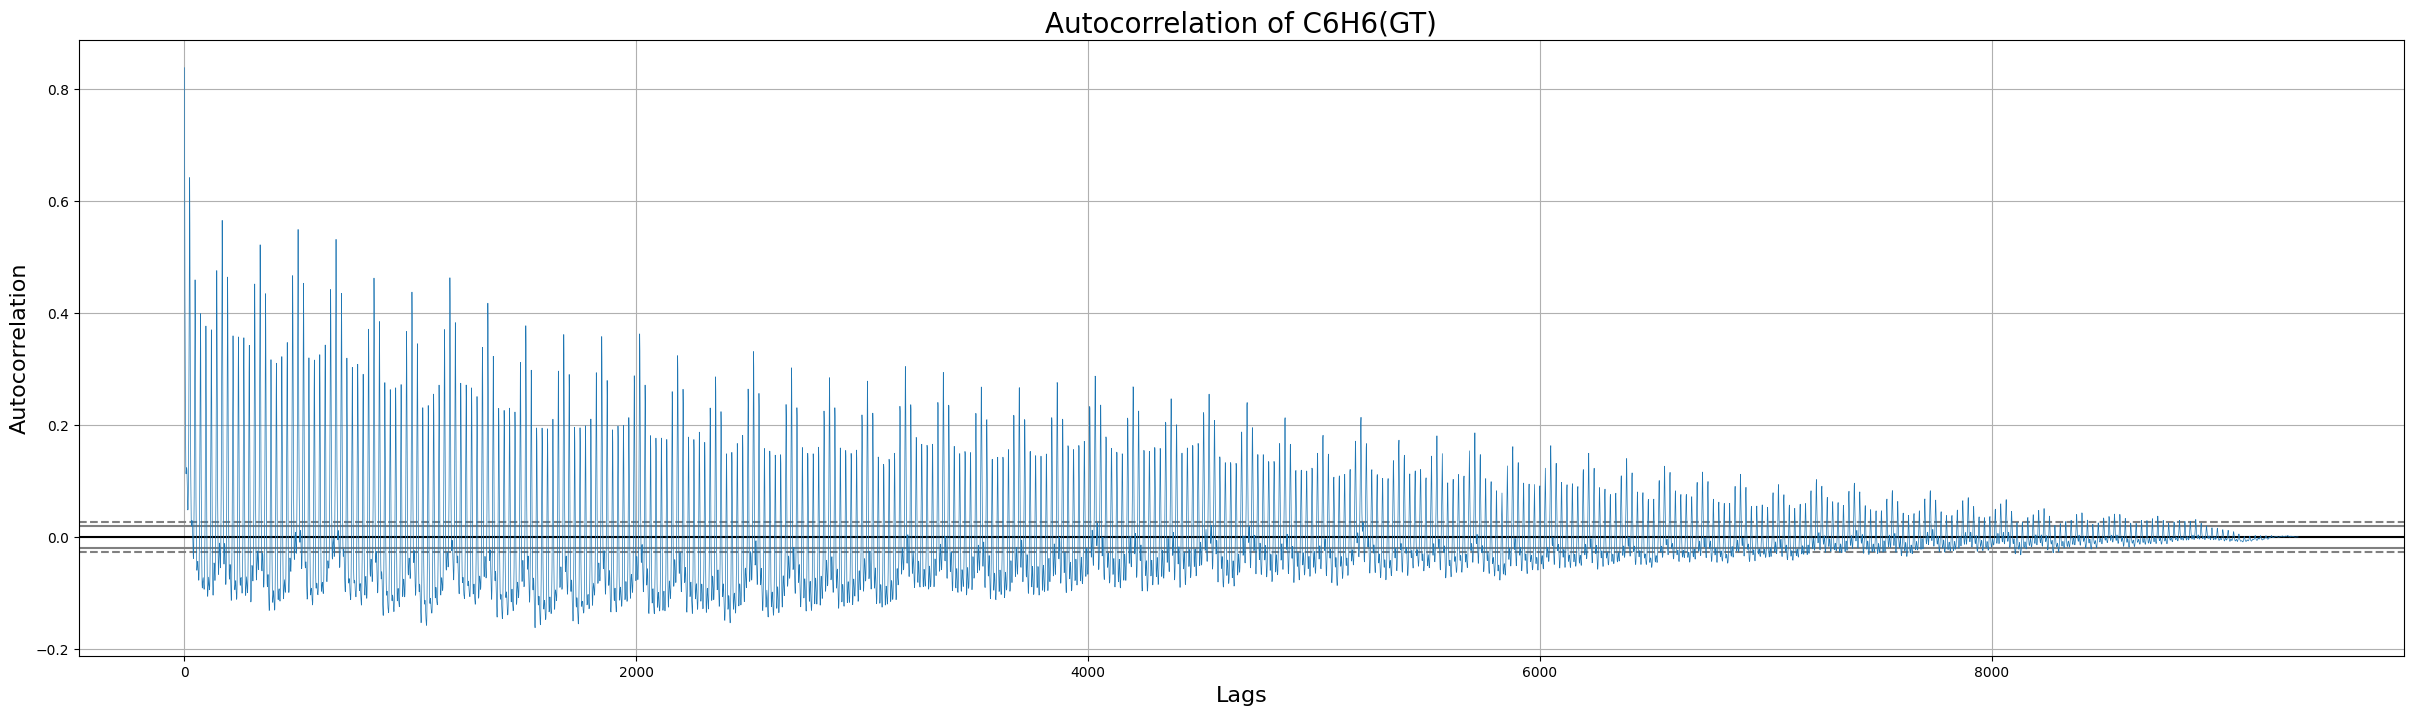

In [ ]:
# Autocorrelation plot
fig, ax = plt.subplots(figsize=(30, 8))

autocorrelation_plot(df['C6H6(GT)'], ax=ax, linewidth=0.5)

ax.set_title('Autocorrelation of C6H6(GT)', fontsize=20)
ax.set_xlabel('Lags', fontsize=16)
ax.set_ylabel('Autocorrelation', fontsize=16)
ax.grid(True)

plt.show()

In [ ]:
# Dataset splitting
p2_train = train2['C6H6(GT)'].values
p2_val = val['C6H6(GT)'].values
p2_ts = test['C6H6(GT)'].values

In [ ]:
# Data reshaping and normalization
scaler = MinMaxScaler(feature_range=(0, 1))

p2_tr_reshaped = p2_train.reshape(-1, 1)
p2_val_reshaped = p2_val.reshape(-1, 1)
p2_ts_reshaped = p2_ts.reshape(-1, 1)

df_for_training_scaled2 = scaler.fit_transform(p2_tr_reshaped)
df_for_val_scaled2 = scaler.transform(p2_val_reshaped)
df_for_test_scaled2 = scaler.transform(p2_ts_reshaped)

In [ ]:
def createXY2(dataset, n_past):
    dataX = []
    dataY = []
    # Iterate over the dataset to create sequences of length n_past
    for i in range(n_past, len(dataset)):
        # Create a window of benzene levels from the past n_past time steps
        benzene_window = dataset[i - n_past:i]
        # Append the benzene window to dataX
        dataX.append(benzene_window)
        # Append the current benzene level to dataY
        dataY.append(dataset[i])
    return np.array(dataX), np.array(dataY)

# Create sequences of 12 past time steps for training and validation data
trX2, trY2 = createXY2(df_for_training_scaled2, 12)
valX2, valY2 = createXY2(df_for_val_scaled2, 12)

In [ ]:
def create_model2(units=20, dropout_rate=0.3, optimizer='adam'):
    model = Sequential()
    model.add(Input(shape=(12, 1)))
    model.add(LSTM(units=units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [ ]:
model2 = create_model2()

model2.summary()

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True, start_from_epoch=5)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 20)             │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,781 (6.96 KB)

 Trainable params: 1,781 (6.96 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model2.fit(trX2, trY2, epochs=200, batch_size=64, validation_data=(valX2, valY2), shuffle=False, callbacks=[callback])

Epoch 1/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0201 - val_loss: 0.0161
Epoch 2/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0140 - val_loss: 0.0136
Epoch 3/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0123 - val_loss: 0.0121
Epoch 4/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0112 - val_loss: 0.0108
Epoch 5/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0104 - val_loss: 0.0099
Epoch 6/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0097 - val_loss: 0.0091
Epoch 7/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0091 - val_loss: 0.0086
Epoch 8/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0085 - val_loss: 0.0083
Epoch 9/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0081 - val_loss: 0.0080
Epoch 10/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0077 - val_loss: 0.0076
Epoch 11/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0073 - val_loss: 0.0075
Epoch 12/200
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0

<function matplotlib.pyplot.show(close=None, block=None)>

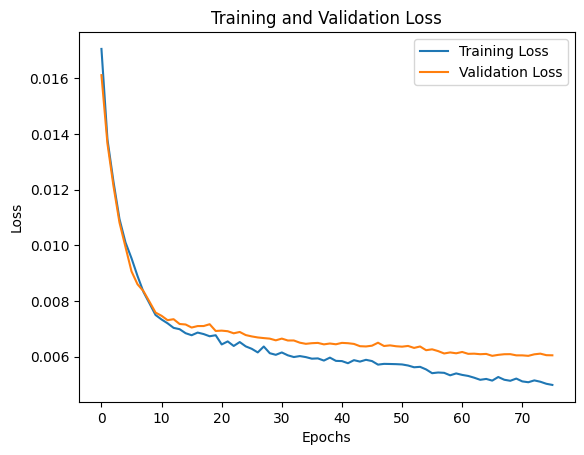

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show

In [ ]:
combined_data2 = np.vstack((df_for_training_scaled2, df_for_val_scaled2))

trX2,trY2=createXY2(combined_data2, 12)
tsX2,tsY2=createXY2(df_for_test_scaled2, 12)

# Retraining on both traning and validation
model2.fit(trX2, trY2, epochs=1, batch_size=64, shuffle=False)

117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0050


In [ ]:
# Model Assessment
test_loss = model2.evaluate(tsX2, tsY2)
print("Test Loss:", test_loss)

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step - loss: 0.0041
Test Loss: 0.003766077570617199


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


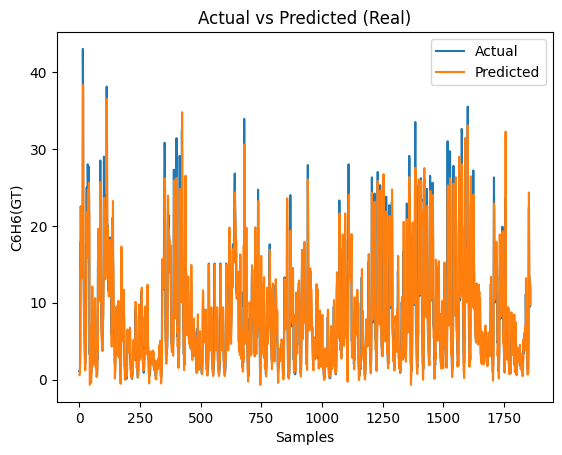

In [ ]:
# Model prediction on test set
predictions2 = model2.predict(tsX2)


# Rescaling predictions and original data back to their original form
prediction_copies_array2 = np.repeat(predictions2, 1, axis=-1)
pred2=scaler.inverse_transform(np.reshape(prediction_copies_array2,(len(predictions2), 1)))[:,-1]

original_copies_array2 = np.repeat(tsY2,1 , axis=-1)
original2=scaler.inverse_transform(np.reshape(original_copies_array2,(len(tsY2),1)))[:,-1]


plt.plot(original2, label='Actual')
plt.plot(pred2, label='Predicted')
plt.xlabel('Samples')
plt.ylabel('C6H6(GT)')
plt.title('Actual vs Predicted (Real)')
plt.legend()
plt.show()

For this problem, the first step was to visualize the autocorrelation of the C6H6 series. Again, particularly around lag 0, the values are quite high, so we expect that a model trained with C6H6 values up to time t will be able to predict benzene levels at time t+1 with reasonable accuracy.

An LSTM model was chosen once again, and the same steps were followed: data normalization, reshaping the data into a form usable by the model (sequences of the 12 previous observations up to time t to predict the value at time t+1), training, and testing. Here too, we observe that the obtained loss is quite low and the model’s predictions closely match the actual data.

Therefore, based solely on the prediction graphs, it is not easy to determine which model performs better. It is necessary to analyze the errors of both models in more detail.



## Error analysis

In [ ]:
def analysis(prediction, original, model):

    c = "(Model 1)" if model == 1 else "(Model 2)"

    predictions = [x for x in prediction]

    # Calculate residuals
    residuals = [original[i] - predictions[i] for i in range(len(predictions))]
    residuals_df = DataFrame(residuals, columns=['residuals'])
    plots = {}

    # Plot of residuals
    fig, ax = plt.subplots()
    residuals_df.plot(ax=ax)
    ax.set_title(f"Residuals Over Time {c}")
    plots['residuals_plot'] = fig
    plt.close(fig)

    # Descriptive statistics
    description = residuals_df.describe()

    # Histogram of residuals
    fig, ax = plt.subplots()
    residuals_df.hist(ax=ax)
    ax.set_title(f"Histogram of Residuals {c}")
    plots['histogram'] = fig
    plt.close(fig)

    # Density plot of residuals
    fig, ax = plt.subplots()
    residuals_df.plot(kind='kde', ax=ax)
    ax.set_title(f"Density Plot of Residuals {c}")
    plots['density_plot'] = fig
    plt.close(fig)

    return plots, description


plots1, description1 = analysis(original1, pred1, 1)
plots2, description2 = analysis(original2, pred2, 2)

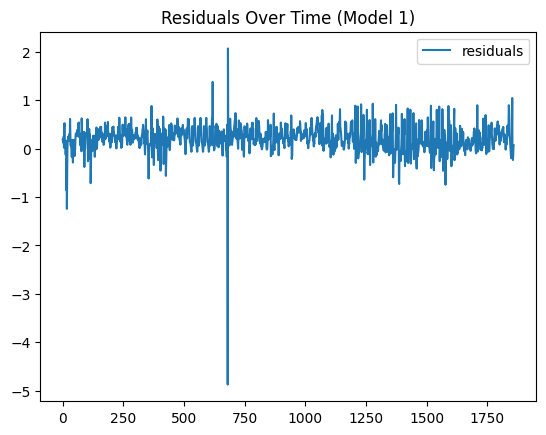

In [ ]:
plots1['residuals_plot']

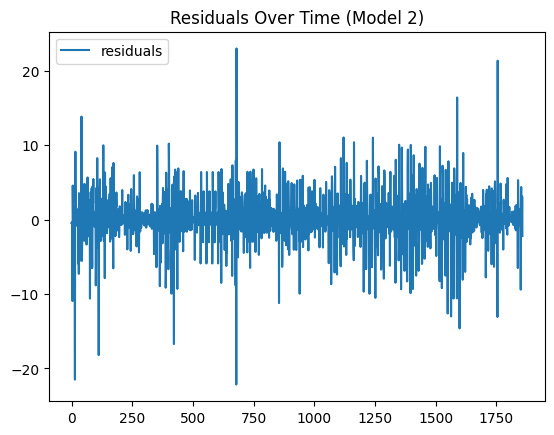

In [ ]:
plots2['residuals_plot']

Firstly, let's analyze the residuals over time: in this graph, each point corresponds to the magnitude of the residual at a specific timestep. We can immediately notice that the range of error values varies significantly between the two models. The primary difference lies in the scale and magnitude of the residuals. The first plot shows smaller, more uniform, and less dispersed residuals, whereas the second plot displays residuals with greater variance and wider dispersion.

The first plot has a narrower range of residuals (approximately from -6 to 2), suggesting more consistent errors. In contrast, the second plot has a wider range (approximately from -20 to 15), indicating greater inconsistency in the errors.

In [ ]:
print("Statistics for the first model")
description1

Statistics for the first model


,residuals
count,1860.000000
mean,0.201608
std,0.257677
min,-4.870436
25%,0.067441
50%,0.207023
75%,0.341743
max,2.065418


In [ ]:
print("Statistics for the second model")
description2

Statistics for the second model


,residuals
count,1859.000000
mean,0.086713
std,3.184695
min,-22.164684
25%,-1.062046
50%,0.031757
75%,1.373193
max,22.991045


To reinforce our conclusions, we compare the statistical summaries for both models. Both models have means close to zero, but the second model has a slightly higher mean residual. The second model also has a significantly higher standard deviation (3.184695) compared to the first model (0.201608), indicating greater variability in the residuals. The residuals of the first model range from -4.870436 to 2.065418, whereas the residuals of the second model range from -22.164684 to 22.991045, showing a much wider spread.

These statistics confirm that the first model's residuals are more tightly clustered around zero with less variability, while the second model's residuals are more dispersed with a larger range. This aligns with the visual analysis of the plots, where the first model exhibited residuals with smaller magnitudes.

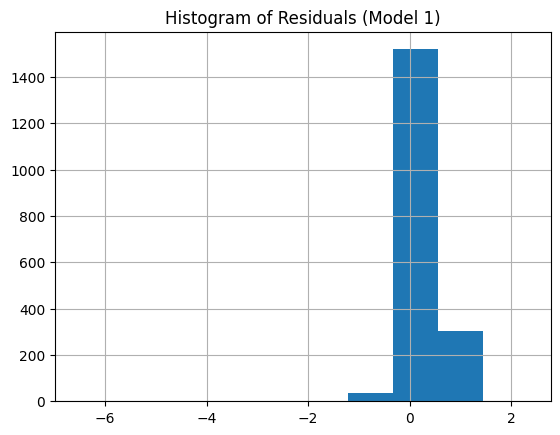

In [ ]:
plots1['histogram']

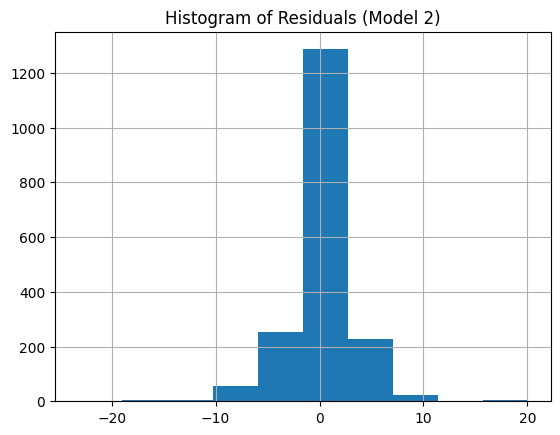

In [ ]:
plots2['histogram']

The histograms further support the previous analysis. The first model demonstrates a better fit, with residuals concentrated around zero, indicating smaller and more consistent errors. In contrast, the second model's residuals spread over a wider range, indicating larger and more variable errors.

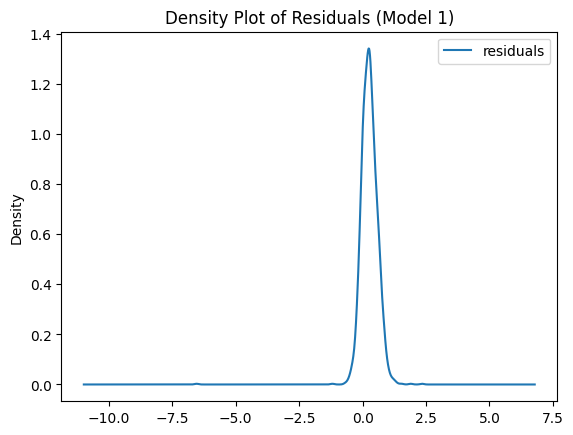

In [ ]:
plots1['density_plot']

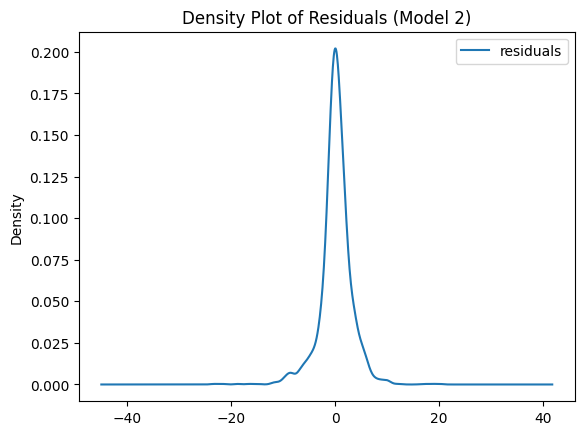

In [ ]:
plots2['density_plot']

The density plots of the residuals reveal that both models have a peak at zero, which is a positive indication: a high concentration of residuals around zero suggests that the model predictions are generally accurate, the model has low bias, and it performs consistently. In the first model, this peak is sharper compared to the second model, indicating smaller and more consistent errors.

## Conclusions

The two models address different problems: the first model tackles a multivariate time series prediction task, while the second model deals with a univariate time series prediction task.

The multivariate model performs well, indicating that the sensor measurements (PT08.* columns) provide valuable information for predicting benzene levels. The univariate model also performs well, but slightly worse than the multivariate model, demonstrating that historical benzene levels alone can still be effectively used for prediction. Both models showing good performance suggests that benzene levels can be predicted using either sensor measurements or historical benzene data. This outcome also indicates that the sensors (PT08.*) are effective in detecting benzene in the air, as expected, given their high correlation with benzene levels observed initially.

## References

- https://medium.com/@786sksujanislam786/multivariate-time-series-forecasting-using-lstm-4f8a9d32a509
- https://machinelearningmastery.com/visualize-time-series-residual-forecast-errors-with-python/
